# MODELO CLASIFICADOR 2 - RESULTADOS SIN ACOPLADO_FR

En el notebook *Modelo_Clasificador_1.ipynb*, extrayendo el atributo *feature_importances* en los modelos entrenados que ofrecen esta información (árboles de decisión) se obtuvo que el feature ACOPLADO_FR no aportaba nada a la reducción de la *impureza de Gini*.

En el notebook *Exploracion_datos.ipynb* guardado en la carpeta "Exploracion_datos" se ponía en duda si considerarlo en el set de entrenamiento como feature de entrada al estar claramente sesgado a que ambos mercados estan desacoplados (ACOPLADO_FR=0).

Ante estos dos resultados compruebo si, para todos los modelos, el *accuracy* mejora al eliminar ACOPLADO_FR en comparación con los resultados obtenidos en *Modelo_Clasificador_1.ipynb*. Utilizo el mismo set de training y test (excepto la variable ACOPLADO_FR) y calculo de nuevo con GridSearchCV los hiperparámetros óptimos en cada caso. 

**Librerías necesarias**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import altair as alt

%matplotlib inline
plt.style.use('ggplot')

#Librerías para modelos

#k-neighbors
from sklearn.neighbors import KNeighborsClassifier
#SVC
from sklearn.svm import SVC
#Arbol de decision
from sklearn.tree import DecisionTreeClassifier
#Regresión logística
from sklearn.linear_model import LogisticRegression
#Para agrupar clasificadores
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report, confusion_matrix, precision_score

#Para representar el arbol

import pydotplus
from IPython.display import Image
from ipywidgets import interact
from sklearn import tree

In [2]:
pd.options.display.max_columns= None

### 1) Descarga train_test_set

In [3]:
path='/Users/blancabengoa/Desktop/KSchool/TFM/Modelo1/'

In [4]:
X_train = pickle.load(open(path + "X_train.pkl","rb"))
X_test = pickle.load(open(path + "X_test.pkl","rb"))
y_train = pickle.load(open(path + "y_train.pkl","rb"))
y_test = pickle.load(open(path + "y_test.pkl","rb"))

In [5]:
X_train.drop('ACOPLADO_FR',axis=1, inplace=True)
X_test.drop('ACOPLADO_FR',axis=1, inplace=True)

In [6]:
X_train.shape

(21040, 11)

In [7]:
X_test.shape

(5261, 11)

In [8]:
attributes_column=list(X_train.columns)
attributes_column

['PERIODO',
 'MES',
 'WD',
 'PRECIO_MD_ESP',
 'RESERVA_D-1',
 'P48_EOLICA',
 'P48_DEMANDA',
 'POT_DISP_CARBON',
 'CARBON_D-1',
 'EMB_ANUALES',
 'EMB_HIPERANUALES']

### 2) Pruebo diferentes modelos

Utilizo **GridSearchCV** para ajustar hiperparámetros.

Como métrica utilizo **accuracy**: porcentaje total de los aciertos del modelo.


#### a) KNN

In [9]:
clfk=GridSearchCV(KNeighborsClassifier(n_neighbors=1),
                 param_grid={"n_neighbors": [3,5,7,15,100]},
                 scoring="accuracy",
                 cv=10)

clfk.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 15, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [10]:
clfk.best_params_

{'n_neighbors': 3}

In [11]:
clfk.best_score_

0.6381178707224334

In [12]:
clfk_2=clfk.best_estimator_

In [13]:
clfk_2.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [14]:
accuracy_score(y_test, clfk_2.predict(X_test))

0.6468352024329975

#### b) SVC

In [15]:
clfsvc=GridSearchCV(SVC(kernel="rbf",C=1,gamma=1,random_state=42),  
                 param_grid={"gamma": [10,100,1000,10000],"C":[0.1,1,10]},    
                 scoring="accuracy",
                 cv=5)
clfsvc.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [10, 100, 1000, 10000], 'C': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [16]:
clfsvc.best_params_

{'C': 0.1, 'gamma': 10}

In [17]:
clfsvc.best_score_

0.5767585551330798

In [21]:
clfsvc_2=clfsvc.best_estimator_

In [22]:
clfsvc_2.fit(X_train,y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
accuracy_score(y_test, clfsvc_2.predict(X_test))

0.5708040296521574

#### c) Decission Tree

In [24]:
clfd = GridSearchCV(DecisionTreeClassifier(min_samples_leaf=20,max_depth=3,random_state=42),
                            param_grid={"min_samples_leaf": [10,20,30,50,100,150,200,250], "max_depth":range(2,7)},
                               scoring="accuracy",
                               cv=10)
clfd.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [10, 20, 30, 50, 100, 150, 200, 250], 'max_depth': range(2, 7)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [25]:
clfd.best_params_

{'max_depth': 6, 'min_samples_leaf': 20}

In [26]:
clfd.best_score_

0.6066539923954373

In [27]:
clfd_2=clfd.best_estimator_

In [28]:
clfd_2.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

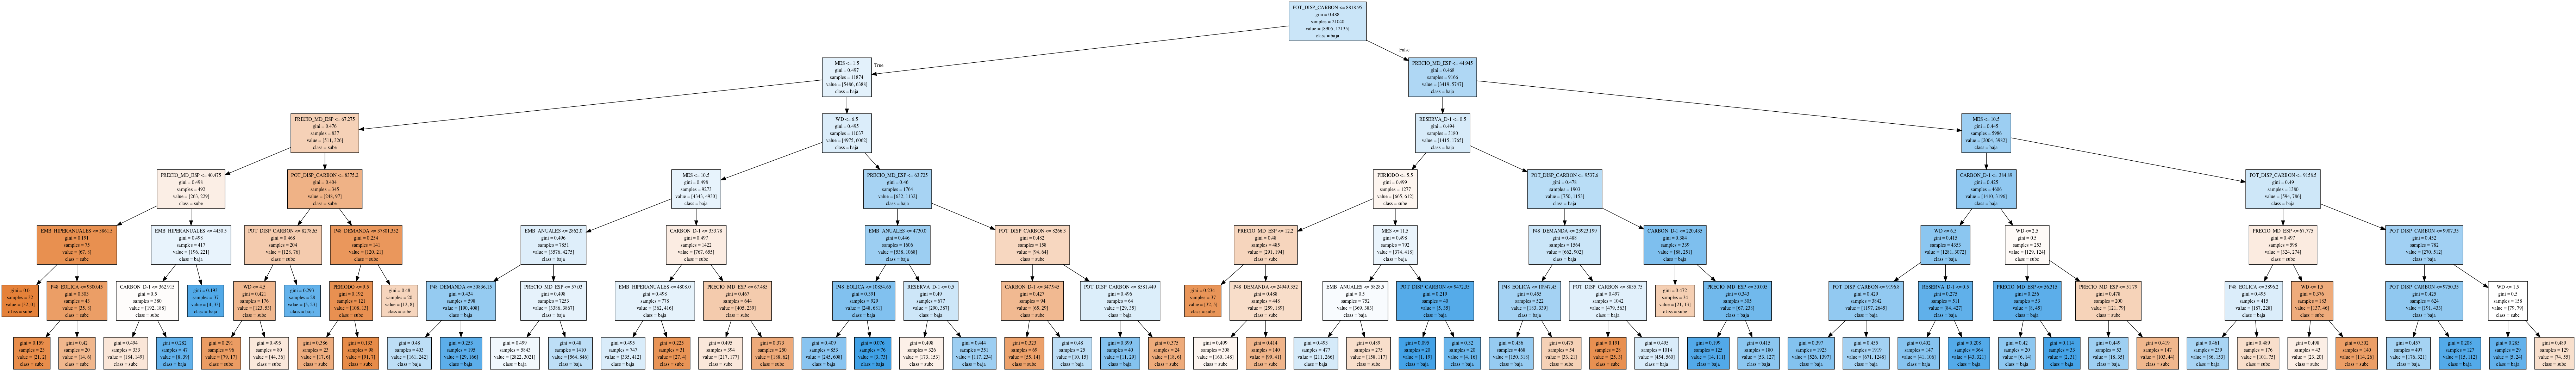

In [29]:
dot_data = tree.export_graphviz(clfd_2,
                                out_file=None, 
                                filled=True,                           #filled le pone un color en funcion de la clase
                                feature_names=attributes_column,
                                class_names=["sube","baja"])            

graph=pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [30]:
accuracy_score(y_test, clfd_2.predict(X_test))

0.6076791484508649

In [31]:
importances = clfd_2.feature_importances_

indices = np.argsort(importances)[::-1]

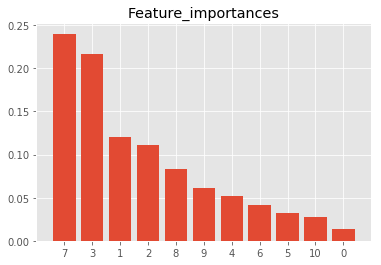

['POT_DISP_CARBON', 'PRECIO_MD_ESP', 'MES', 'WD', 'CARBON_D-1', 'EMB_ANUALES', 'RESERVA_D-1', 'P48_DEMANDA', 'P48_EOLICA', 'EMB_HIPERANUALES', 'PERIODO']


In [32]:
plt.figure()
plt.title("Feature_importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

print(list([attributes_column[i] for i in indices]))

#### d) Random Forest

In [9]:
clfr = GridSearchCV(RandomForestClassifier(n_estimators=200, oob_score=True,random_state=42),
                          param_grid={"min_samples_leaf": [10, 20, 30, 50, 100, 150, 200, 250,500],
                                      'max_depth': range(2, 7, 500),
                                      'n_estimators': [100, 200, 500]},
                          scoring="accuracy",
                          cv=10)
clfr.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [10, 20, 30, 50, 100, 150, 200, 250, 500], 'max_depth': range(2, 7, 500), 'n_estimators': [100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [10]:
clfr.best_params_

{'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 100}

In [11]:
clfr.best_score_

0.5828422053231939

In [12]:
clfr_2=clfr.best_estimator_

In [13]:
clfr_2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

**Ejemplo de árboles que lo forman (100):**

In [14]:
n=20 #Cambiando este valor se muestran distintos árboles.

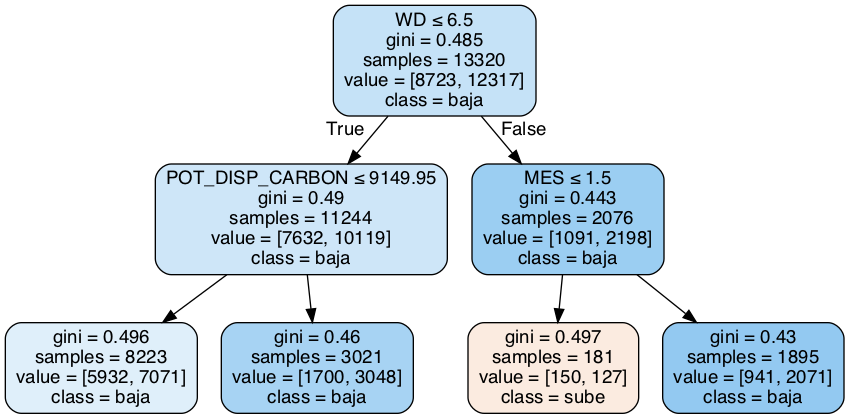

In [15]:
dot_data = tree.export_graphviz(clfr_2.estimators_[n], out_file=None, 
                         filled=True, rounded=True,  
                         special_characters=True,
                         feature_names=attributes_column,
                         class_names=["sube","baja"])  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png()) 

In [41]:
accuracy_score(y_test, clfr_2.predict(X_test))

0.5778369131343851

In [42]:
importances = clfr_2.feature_importances_

indices = np.argsort(importances)[::-1]

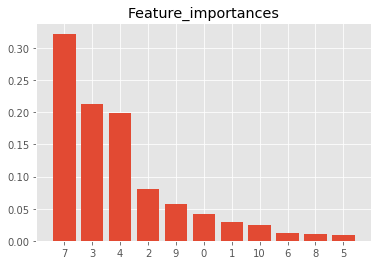

['POT_DISP_CARBON', 'PRECIO_MD_ESP', 'RESERVA_D-1', 'WD', 'EMB_ANUALES', 'PERIODO', 'MES', 'EMB_HIPERANUALES', 'P48_DEMANDA', 'CARBON_D-1', 'P48_EOLICA']


In [43]:
plt.figure()
plt.title("Feature_importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

print(list([attributes_column[i] for i in indices]))

#### e) XGBOOST

In [44]:
clfxb = GridSearchCV(XGBClassifier(n_estimators=100,random_state=42),
                    param_grid={'n_estimators': [100, 200, 500]},
                    scoring="accuracy",
                    cv=5)
clfxb.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [45]:
clfxb.best_params_

{'n_estimators': 500}

In [46]:
clfxb.best_score_

0.6826520912547529

In [47]:
clfxb_2=clfxb.best_estimator_

In [48]:
clfxb_2.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [49]:
accuracy_score(y_test, clfxb_2.predict(X_test))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6973959323322563

In [50]:
importances = clfxb_2.feature_importances_

indices = np.argsort(importances)[::-1]

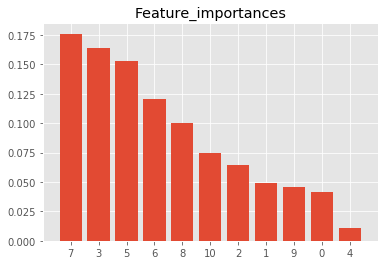

['POT_DISP_CARBON', 'PRECIO_MD_ESP', 'P48_EOLICA', 'P48_DEMANDA', 'CARBON_D-1', 'EMB_HIPERANUALES', 'WD', 'MES', 'EMB_ANUALES', 'PERIODO', 'RESERVA_D-1']


In [51]:
plt.figure()
plt.title("Feature_importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

print(list([attributes_column[i] for i in indices]))

#### f) Bagging

In [52]:
clfb = GridSearchCV(BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),n_estimators=100,oob_score=True,random_state=42),
                    param_grid={"n_estimators": [100, 200, 500]},
                    scoring="accuracy",
                    cv=5)
clfb.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=True,
         random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [53]:
clfb.best_score_

0.6387832699619772

In [54]:
clfb.best_params_

{'n_estimators': 200}

In [55]:
clfb_2=clfb.best_estimator_
clfb_2.fit(X_train,y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=200, n_jobs=1, oob_score=True,
         random_state=42, verbose=0, warm_start=False)

In [56]:
accuracy_score(y_test, clfb_2.predict(X_test))

0.6525375403915605

### 3) Análisis de resultados:

In [57]:
modelos=[clfk_2,clfsvc_2,clfd_2,clfr_2,clfxb_2,clfb_2]

Traigo resultados obtenidos en *Modelo_Clasificador_1.ipynb* para comparar:

In [58]:
modelos1=[]
names1= ['clfk_1','clfsvc_1','clfd_1','clfr_1','clfxb_1','clfb_1']
path1='/Users/blancabengoa/Desktop/KSchool/TFM/Modelo1/'

for k,n in enumerate(names1):
    modelos1.append(pickle.load(open(path1 + str(n) +".pkl","rb")))

Me traigo también X_test guardado de Modelo1.

In [59]:
X_test1=pickle.load(open(path1 + "X_test.pkl","rb"))
y_test1=pickle.load(open(path1 + "y_test.pkl","rb"))

In [60]:
X_test1.head()

,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES
18303,18,11,7,51.47,1,0,5128.7,23559.8,8081.6,350.85,2222,2182
24612,16,7,7,61.15,0,0,1900.9,26608.3,9495.0,343.00,5726,4521
2973,22,2,1,55.55,0,1,1620.7,34739.3,9393.2,313.92,6078,5988
22501,17,4,3,42.08,0,1,6711.6,30367.2,8181.4,414.50,7076,4822
4699,21,4,3,28.40,0,1,6437.3,31333.7,7831.9,294.38,6841,6339


In [61]:
X_test1.shape

(5261, 12)

In [62]:
y_test1.shape

(5261,)

**Clasification Report**

In [63]:
for k,m in enumerate(modelos):
    print('Modelo ' + list(str(m).split("("))[0] + '\n')
    print(classification_report(y_test,m.predict(X_test)) , classification_report(y_test1,modelos1[k].predict(X_test1)))

Modelo KNeighborsClassifier

             precision    recall  f1-score   support

          0       0.60      0.55      0.57      2258
          1       0.68      0.72      0.70      3003

avg / total       0.64      0.65      0.64      5261
              precision    recall  f1-score   support

          0       0.60      0.55      0.57      2258
          1       0.68      0.72      0.70      3003

avg / total       0.64      0.65      0.64      5261

Modelo SVC



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2258
          1       0.57      1.00      0.73      3003

avg / total       0.33      0.57      0.41      5261
              precision    recall  f1-score   support

          0       0.00      0.00      0.00      2258
          1       0.57      1.00      0.73      3003

avg / total       0.33      0.57      0.41      5261

Modelo DecisionTreeClassifier

             precision    recall  f1-score   support

          0       0.62      0.23      0.33      2258
          1       0.61      0.89      0.72      3003

avg / total       0.61      0.61      0.56      5261
              precision    recall  f1-score   support

          0       0.62      0.23      0.33      2258
          1       0.61      0.89      0.72      3003

avg / total       0.61      0.61      0.56      5261

Modelo RandomForestClassifier

             precision    recall  f1-score   support

          0       0.80  

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

          0       0.70      0.51      0.59      2258
          1       0.70      0.84      0.76      3003

avg / total       0.70      0.70      0.69      5261
              precision    recall  f1-score   support

          0       0.70      0.50      0.59      2258
          1       0.69      0.84      0.76      3003

avg / total       0.70      0.70      0.69      5261

Modelo BaggingClassifier

             precision    recall  f1-score   support

          0       0.60      0.55      0.58      2258
          1       0.68      0.73      0.71      3003

avg / total       0.65      0.65      0.65      5261
              precision    recall  f1-score   support

          0       0.60      0.55      0.58      2258
          1       0.68      0.73      0.71      3003

avg / total       0.65      0.65      0.65      5261



In [64]:
for k,m in enumerate(modelos):
    print('Precision: \n' + list(str(m).split("("))[0])
    print('%.2f' %precision_score(y_test,m.predict(X_test)) + ', %.2f' %precision_score(y_test1,modelos1[k].predict(X_test1))  + '\n')

for k,m in enumerate(modelos):
    print('Accuracy: \n' + list(str(m).split("("))[0])
    print('%.2f' %accuracy_score(y_test,m.predict(X_test)) + ', %.2f' %accuracy_score(y_test1,modelos1[k].predict(X_test1)) + '\n')

Precision: 
KNeighborsClassifier
0.68, 0.68

Precision: 
SVC
0.57, 0.57

Precision: 
DecisionTreeClassifier
0.61, 0.61

Precision: 
RandomForestClassifier
0.58, 0.58

Precision: 
XGBClassifier


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.70, 0.69

Precision: 
BaggingClassifier
0.68, 0.68

Accuracy: 
KNeighborsClassifier
0.65, 0.65

Accuracy: 
SVC
0.57, 0.57

Accuracy: 
DecisionTreeClassifier
0.61, 0.61

Accuracy: 
RandomForestClassifier
0.58, 0.58

Accuracy: 
XGBClassifier


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.70, 0.70

Accuracy: 
BaggingClassifier
0.65, 0.65



**Matriz de Confusión**

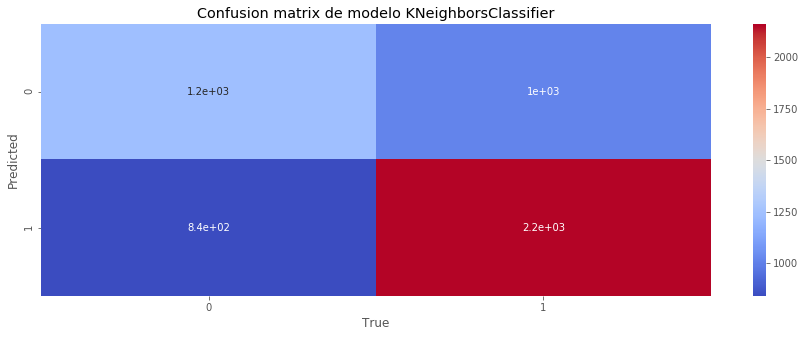

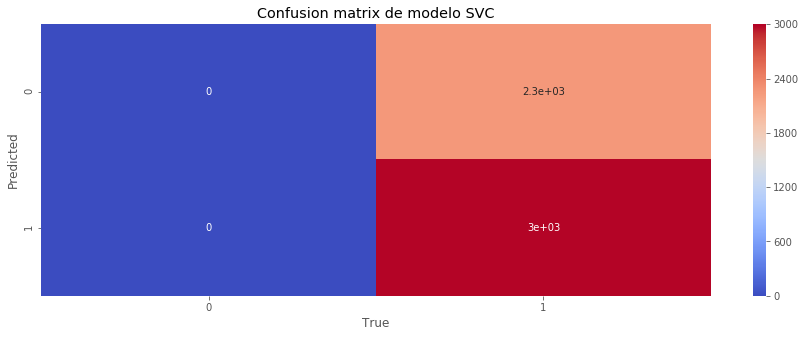

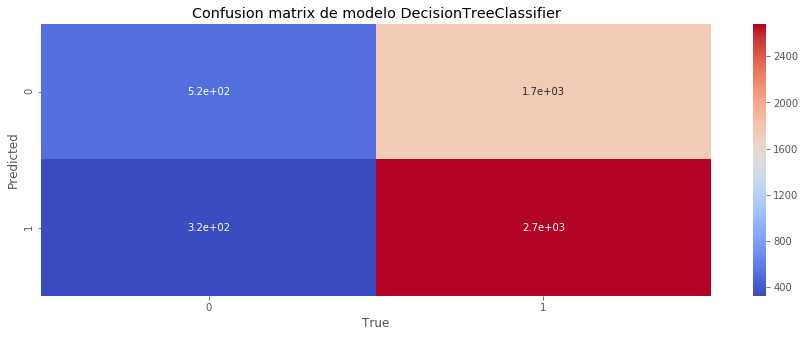

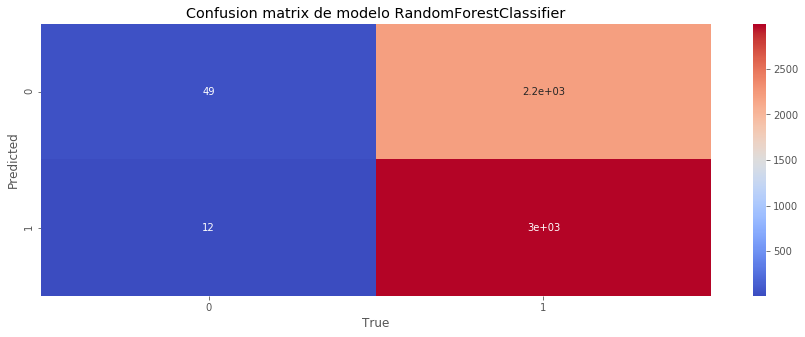

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


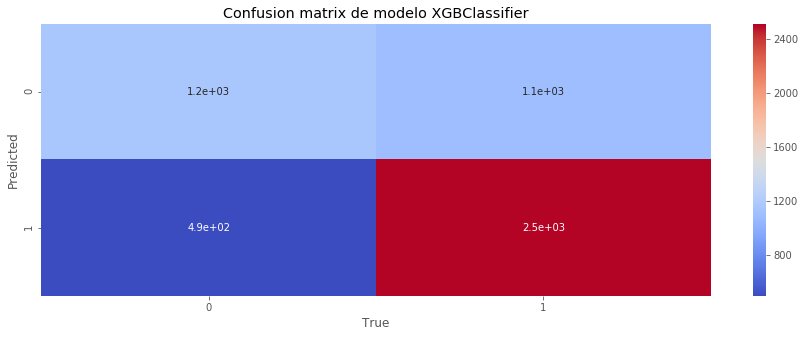

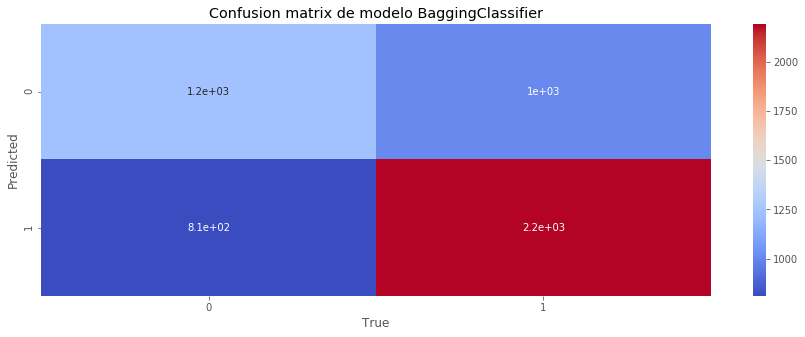

In [65]:
for k,m in enumerate(modelos):
    plt.figure(figsize=(15,5))
    cmatrix=confusion_matrix(y_test,m.predict(X_test))
    sns.heatmap(data = cmatrix, 
                annot=True,
                xticklabels=[0,1], 
                yticklabels=[0,1],
                cmap='coolwarm')
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.title('Confusion matrix de modelo ' + list(str(m).split("("))[0])
    plt.show()

Los resultados no han variado con respecto al *Modelo_Clasificador_1.ipynb*. Por tanto, para posteriores análisis y de cara a quedarme con el mejor modelo:

**ELIMINO LA VARIABLE ACOPLADO_FR DE MIS FEATURES DE ENTRADA CON EL FIN DE MEJORAR EL RENDIMIENTO EN LA FASE DE ENTRENAMIENTO Y NO APORTAR MEJORA EL CONSIDERARLA.**

Guardo los modelos obtenidos (ya entrenados) y la división del train_test_set.

**NOTA: Originalmente los guardo en una carpeta fuera de mi repositorio porque pesan mucho (sobretodo BaggingClassifier) y no quiero subirlos todos a github.**

Si se quieren guardar estos modelos para hacer cualquier comprobación al ejecutar este notebook, escribir en la variable *path* la ruta local donde se quieran almacenar.

In [66]:
names=['clfk_2','clfsvc_2','clfd_2','clfr_2','clfxb_2','clfb_2']
path2='/Users/blancabengoa/Desktop/KSchool/TFM/Modelo2/'   #Aqui es donde debo poner la ruta especifica


In [67]:
for k,m in enumerate(modelos):  
    pickle.dump(m,open(path2 + names[k] +".pkl","wb"))

In [68]:
#set de datos
pickle.dump(X_train,open(path2 + "X_train.pkl","wb"))
pickle.dump(y_train,open(path2+ "y_train.pkl","wb"))
pickle.dump(X_test,open(path2 + "X_test.pkl","wb"))
pickle.dump(y_test,open(path2 + "y_test.pkl","wb"))